# aggregating away the signal in data

I came across this interesting article on [stack overflow](https://stackoverflow.blog/2022/03/03/stop-aggregating-away-the-signal-in-your-data/?utm_source=pocket_mylist) and liked their approach to data exploration and visualisation.

Specifically, I like the intentionality with which they approached exploration: don't smoothen out your data simply because it makes it easier to look at.

They use three approaches to exploring and visualising the data:
* rearrange
* augment
* foreground

To test that I understood the approach, I applied it to a similar set of data [from Kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data)

## disclaimer

I'm not an energy / electricity expert so any suggestions I make re: consequences are probably going to be basic and lacking in nuance.

Please take them with a grain of salt and focus more on the techniques and the insights they can surface 👍🏾

In [1]:
from datetime import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dt_format = "%Y-%m-%d %H:%M:%S"

# data preparation

In [2]:
cols=["datetime", "power_usage"]
df = pd.read_csv("data/AEP_hourly.csv")
df.columns = cols

## date parsing and filtering

We'll focus on the data from December 2016 - November 2017.

The year was chosen somewhat at random. The months were chosen to represent complete seasons (e.g. Winter 2016 - Spring 2017).

In [3]:
df["datetime"] = pd.to_datetime(df["datetime"], format = dt_format)
start_bound_dt = dt.strptime("2014-12-01 00:00:00", dt_format)
end_bound_dt = dt.strptime("2017-11-30 23:59:59", dt_format)
df = df[(df["datetime"] >= start_bound_dt) & (df["datetime"] <= end_bound_dt)].copy()
len(df)

26304

## brief data quality checking

Just going to do some duplicate checking. In order to keep this demonstration focused on the above visualisation and exploration approaches, I will leave out additional data quality checks.

In [4]:
dupes = list(df[df["datetime"].duplicated()]["datetime"].values)
df[df["datetime"].isin(dupes)]

,datetime,power_usage
91275,2015-11-01 02:00:00,10785.0
91276,2015-11-01 02:00:00,10542.0
99915,2016-11-06 02:00:00,10964.0
99916,2016-11-06 02:00:00,11008.0
108723,2017-11-05 02:00:00,10596.0
108724,2017-11-05 02:00:00,10446.0


There are 3 duplicate records. For the purpose of this analysis, I don't think it is critical to treat them and I will leave them as is.

## sorting for quick plotting

Generally, if visualising / plotting time series, I have found the operations to be quicker if the datetime column is sorted.

In [5]:
df.sort_values("datetime", inplace=True, ascending=True)

# initial visualisation

Let's start with a plain old line chart of all the values.

There's a lot going on in this one!

Text(0, 0.5, 'Power Usage (kWh)')

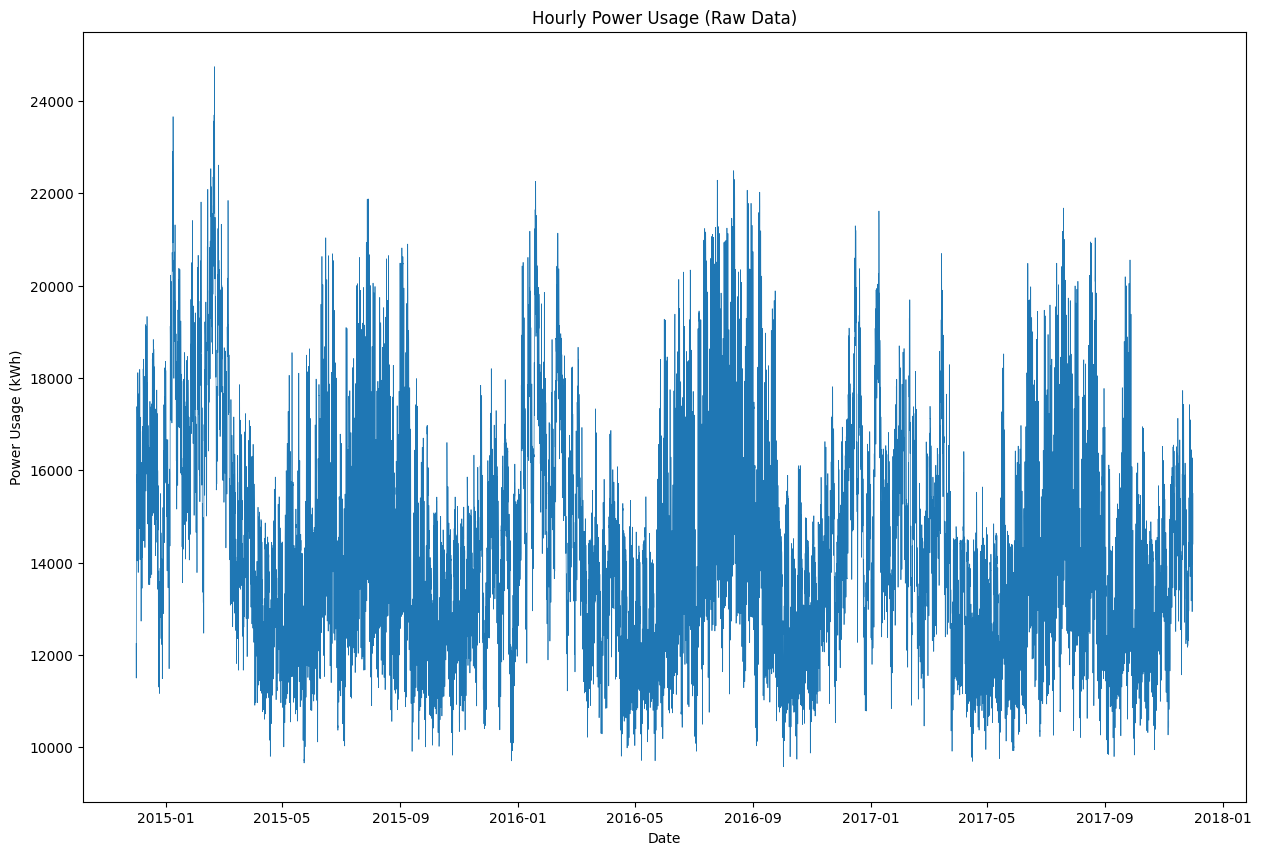

In [6]:
# Set up the plots
plt.figure(figsize=(15, 10))

# Plot 1: Raw data showing chaos
# plt.subplot(2, 1, 1)
sns.lineplot(data=df, x='datetime', y='power_usage', linewidth=0.5)
plt.title('Hourly Power Usage (Raw Data)')
plt.xlabel('Date')
plt.ylabel('Power Usage (kWh)')

# simplifying the data: aggregation

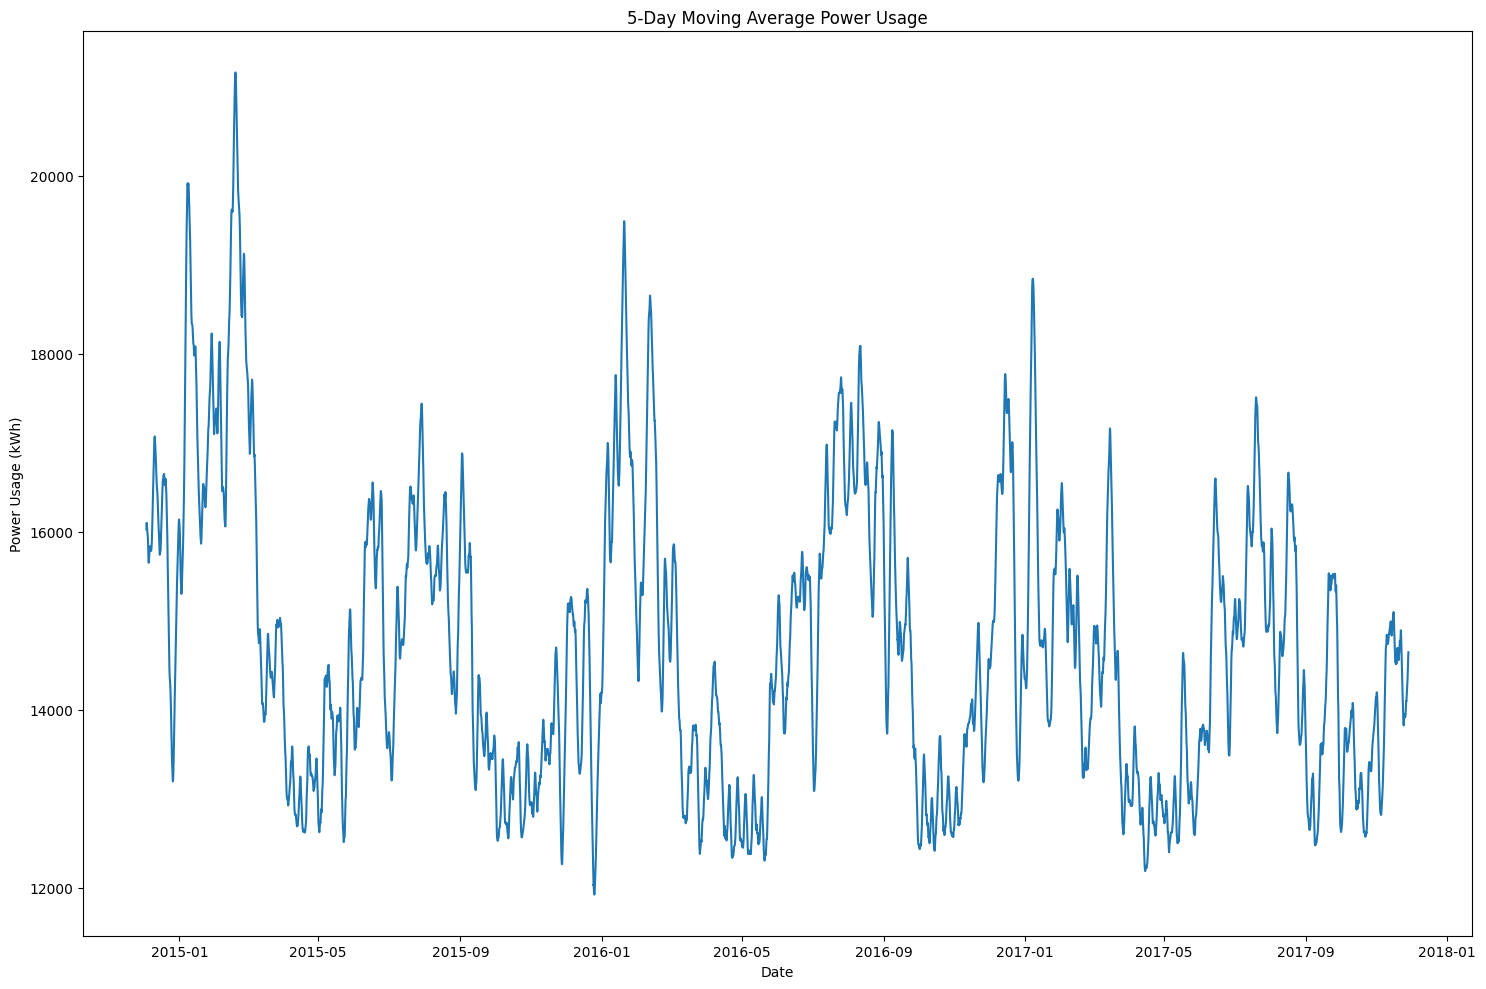

In [7]:
# Plot 2: 5-day moving average
plt.figure(figsize=(15, 10))
df['power_usage_5day_ma'] = df['power_usage'].rolling(window=5*24, center=True).mean()  # 5 days * 24 hours
sns.lineplot(data=df, x='datetime', y='power_usage_5day_ma')
plt.title('5-Day Moving Average Power Usage')
plt.xlabel('Date')
plt.ylabel('Power Usage (kWh)')

plt.tight_layout()
plt.show()

# the problem with aggregation

It can be compelling to reach for a smoothening tool like the 5-day moving average to try and make the data easier to read.

However, what's important are the decisions that are being implicitly made. 

That is, by reflexively reaching for a daily average, we have somewhat arbitrarily decided to smoothen things out at the daily level.

Why not weekly? 

Or why not divide the day into the quarters and aggregate based on day periods? E.g. morning, daytime, evening, and night?

If we are making decisions where we are losing resolution, it is important that they are made consciously. And the best way to do this is to dig further into the data.

We can then allow the insights we get from this deeper analysis to make more informed decisions about aggregation.

# rearranging

Instead of aggregating, we can simply _rearrange_ the data.

Below, I use plot the power usage against the day of the week.

C:\Users\Traitorous Pal\AppData\Local\Temp\ipykernel_3692\555537748.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='day_of_week', y='power_usage', data=df, ax=ax, palette='Set2')
C:\Users\Traitorous Pal\AppData\Local\Temp\ipykernel_3692\555537748.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['day_of_week'].unique(), rotation=90)


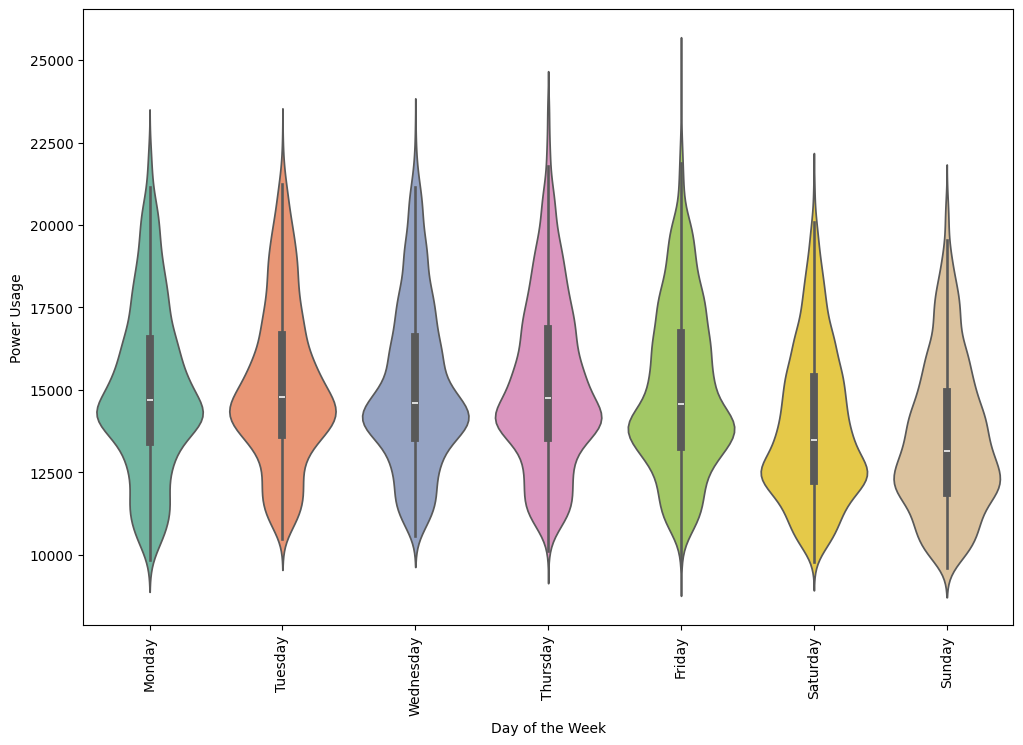

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df['day_of_week'] = df['datetime'].dt.day_name()
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x='day_of_week', y='power_usage', data=df, ax=ax, palette='Set2')

# Adjust the xticklabels
ax.set_xticklabels(df['day_of_week'].unique(), rotation=90)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Power Usage')

plt.show()


Immediately, it can be seen that
* overall power usage decreases on the weekends.
* Fridays have the highest variability in power usage.

This might be useful insight for demand-response programs, or system maintenance window selection.

# augmentation

The next approach is that of _augmentation_

That is, instead of making the data more coarse through aggregation, let's _enrich_ it by adding some things we know about the data.

For example, we know that the following

* there is a seasonal cycle across the year
* there is a 7 day cycle across the weeks
* there are phases to the day in which we may expect power usage to differ (e.g. morning vs evening).

In the following section, I will add some of these categories to the data and then visualise the results.

## first, augment the data

In [9]:
import matplotlib.pyplot as plt

# Define seasons based on months
season_mapping = {
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn',
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring'
}

# Map seasons to the dataframe
df['season'] = df['datetime'].dt.month.map(season_mapping)

## second, plot it

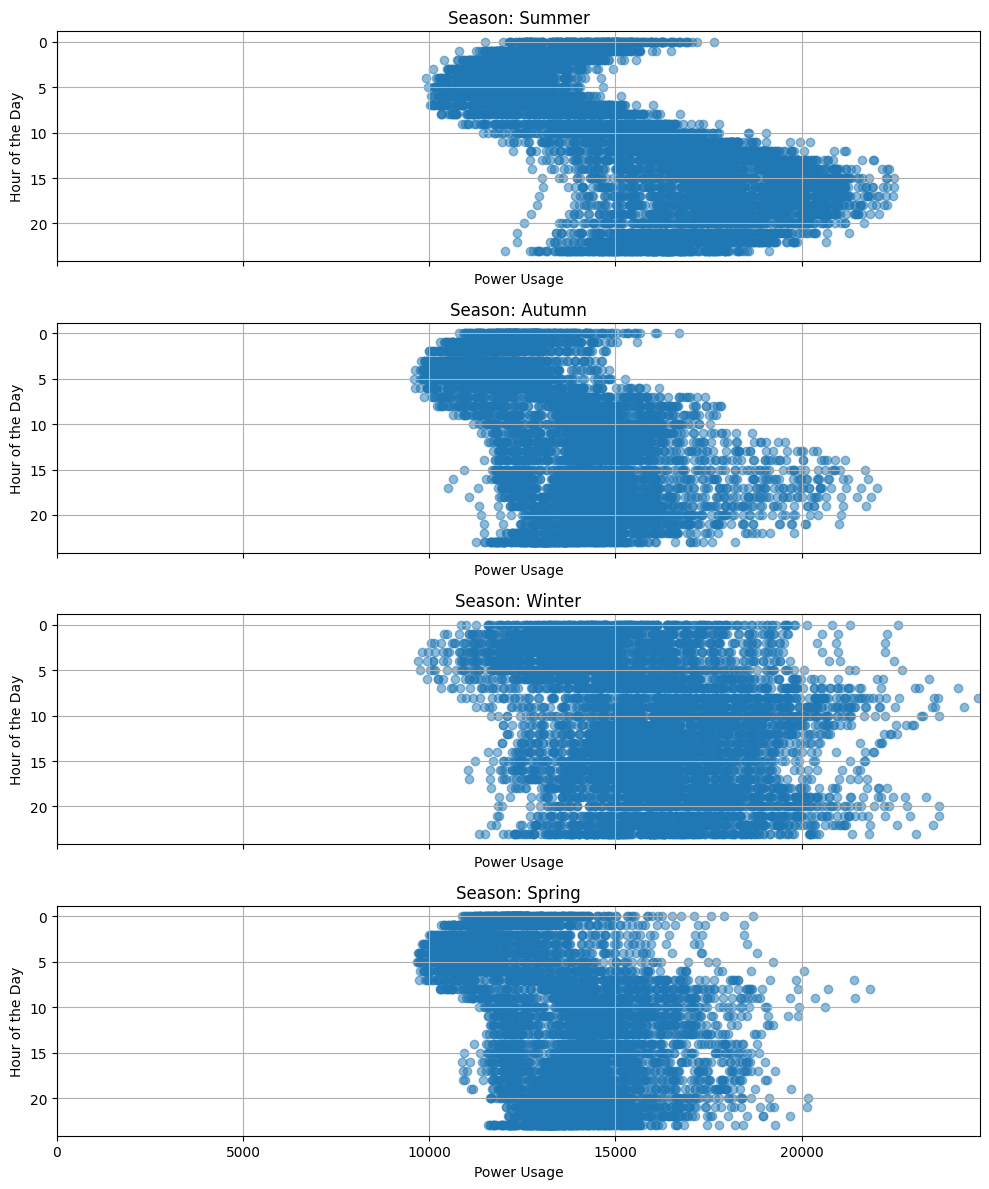

In [10]:
# Create a figure with subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 12), sharex=True)

# Define the order of hours for y-axis
hours = np.arange(23, -1, -1)

# Plot each season on a separate subplot
for i, season in enumerate(['Summer', 'Autumn', 'Winter', 'Spring']):
    ax = axs[i]
    season_data = df[df['season'] == season]
    
    # Plot power usage against hour of the day
    ax.scatter(season_data['power_usage'], season_data['datetime'].dt.hour, alpha=0.5)
    
    # Set labels and title
    ax.set_xlabel('Power Usage')
    ax.set_ylabel('Hour of the Day')
    ax.set_title(f'Season: {season}')
    
    # Invert y-axis to show midnight at the top
    ax.invert_yaxis()
    
    # Set x-axis limits based on the overall data range for consistency
    ax.set_xlim(0, df['power_usage'].max() + 50)  # Adjusted for better visibility
    
    # Add grid for better readability
    ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

There's a sharp upturn that happens around afternoons during Summer that is easier to pick from the faceted graphs.

Power usage in Winter on the other hand is more evenly distributed throughout the day (though there appears to be a slight bimodal peak around mid-morning (9AM) and late evening (8PM).

In Spring, the power usage seems to be the most evenly distributed across the hours of the day.

These insights might be useful in designing demand-response programs: there is probably higher leverage in employing these in Summer than Winter (and even less so in Spring). That is, it might make sense to encourage people to move their power usage to earlier in the day in Summer, away from the better defined peak time. 

# background and foreground

If we are interested in digging deeper into the pronounced peaks and troughs in Summer, we can take a look at how the data behaves in a given year.

A common approach might be to plot each year on its own subplot and flick between the subplots and try to pick up differences.

However, a method that is somewhat easier on the eyes is to plot the entire set of data and use hues to highlight the subject of each scatterplot.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract hour from datetime column
df['hour'] = df['datetime'].dt.hour

# going to use these custom bounds for the years so I can capture the seasons neatly
df.loc[
    (df["datetime"] >= dt.strptime("2014-12-01 00:00:00", dt_format)) &
    (df["datetime"] <= dt.strptime("2015-11-30 23:59:59", dt_format)), "year"] = "2015"
df.loc[
    (df["datetime"] >= dt.strptime("2015-12-01 00:00:00", dt_format)) &
    (df["datetime"] <= dt.strptime("2016-11-30 23:59:59", dt_format)), "year"] = "2016"
df.loc[
    (df["datetime"] >= dt.strptime("2016-12-01 00:00:00", dt_format)) &
    (df["datetime"] <= dt.strptime("2017-11-30 23:59:59", dt_format)), "year"] = "2017"

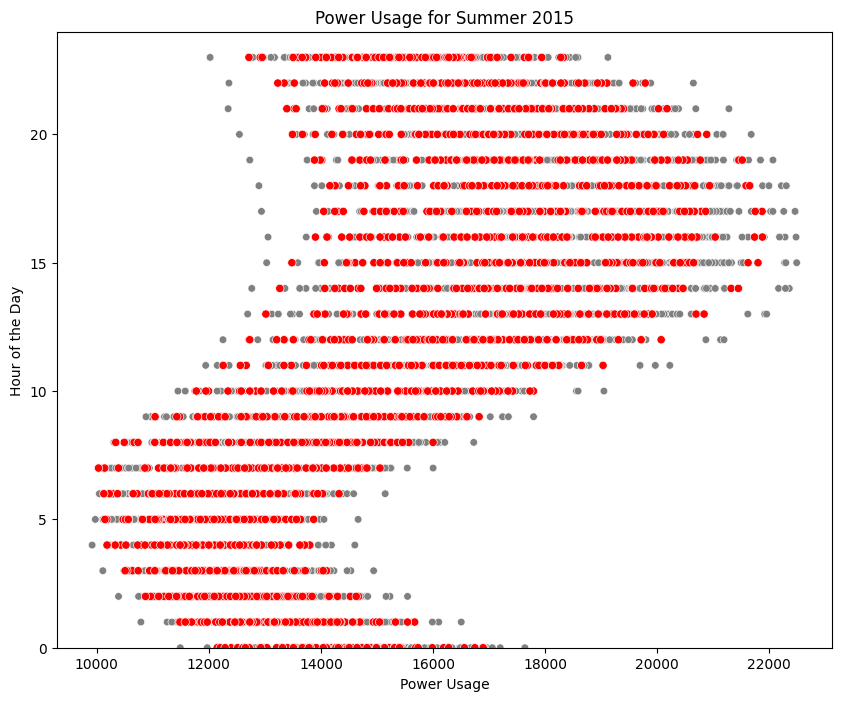

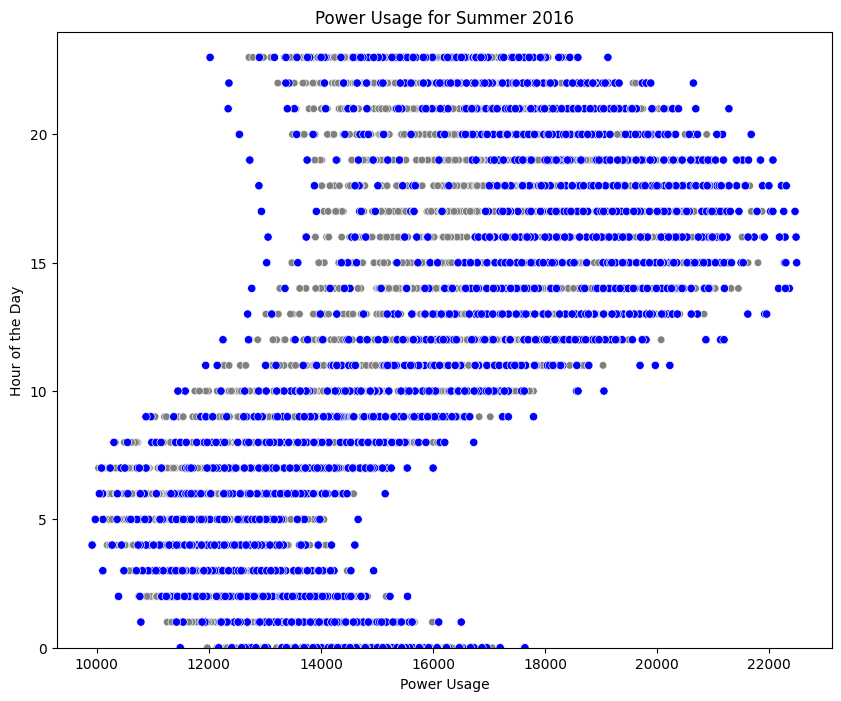

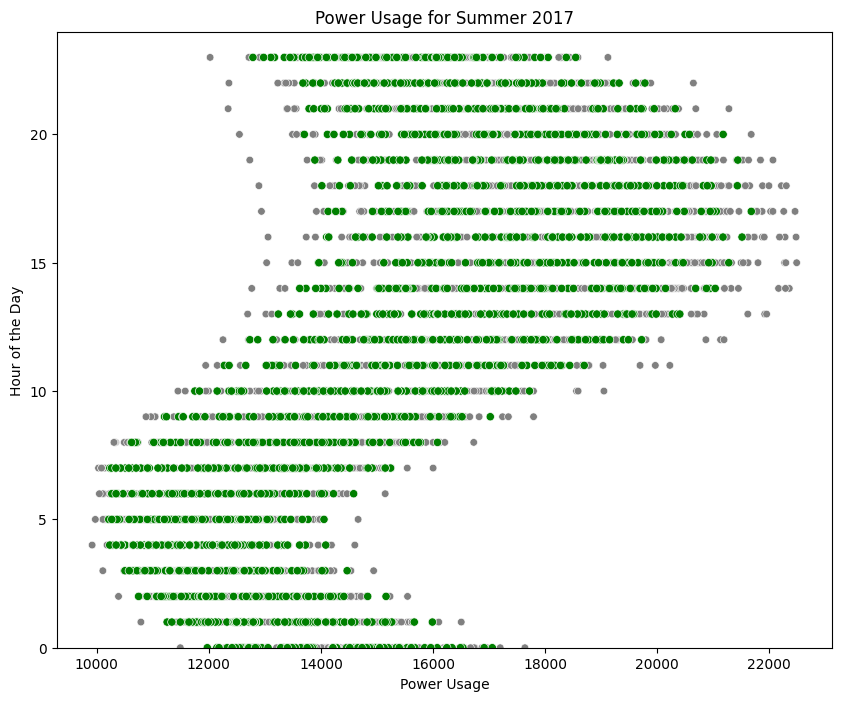

In [12]:
years = ["2015", "2016", "2017"]
colors = ['red', 'blue', 'green']
year_color_map = dict(zip(years, colors))


summer_df = df[df["season"] == "Summer"].copy()

for year in years:
    # Filter data for the specific year and keep the other years as background data
    year_df = summer_df[summer_df['year'] == year].copy()
    other_years_df = summer_df[summer_df['year'] != year].copy()
    # Map all other years to 'Other'
    other_years_df['year'] = 'Other'
    
    # Create the scatter plots
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(x='power_usage', y='hour', hue='year', data=other_years_df, ax=ax, palette='grey', s=30)
    sns.scatterplot(x='power_usage', y='hour', hue='year', data=year_df, ax=ax, palette=year_color_map)

    # Set title, labels, and limits for the plot
    ax.set_title(f'Power Usage for Summer {year}')
    ax.set_xlabel('Power Usage')
    ax.set_ylabel('Hour of the Day')
    ax.set_ylim(0, 24)
    ax.get_legend().remove()
    plt.show()

In these visualisations, it seems like the Summer of 2016 was somewhat uncharacteristic in that:
* it contained the extremes of high and low power usage
* these extremes are exhibited across all hours of the day

As a result, decision-makers may choose to dig deeper into why Summer 2016 had these extreme values. Or, they may choose to exclude these outliers or even the entire season from aggregate analyses.

Whichever they choose, their decision will be more informed because we didn't rush to aggregate and smooth over the data.

As a reminder of how sparse the picture is with early aggregation, here is the pair of plots we started with.

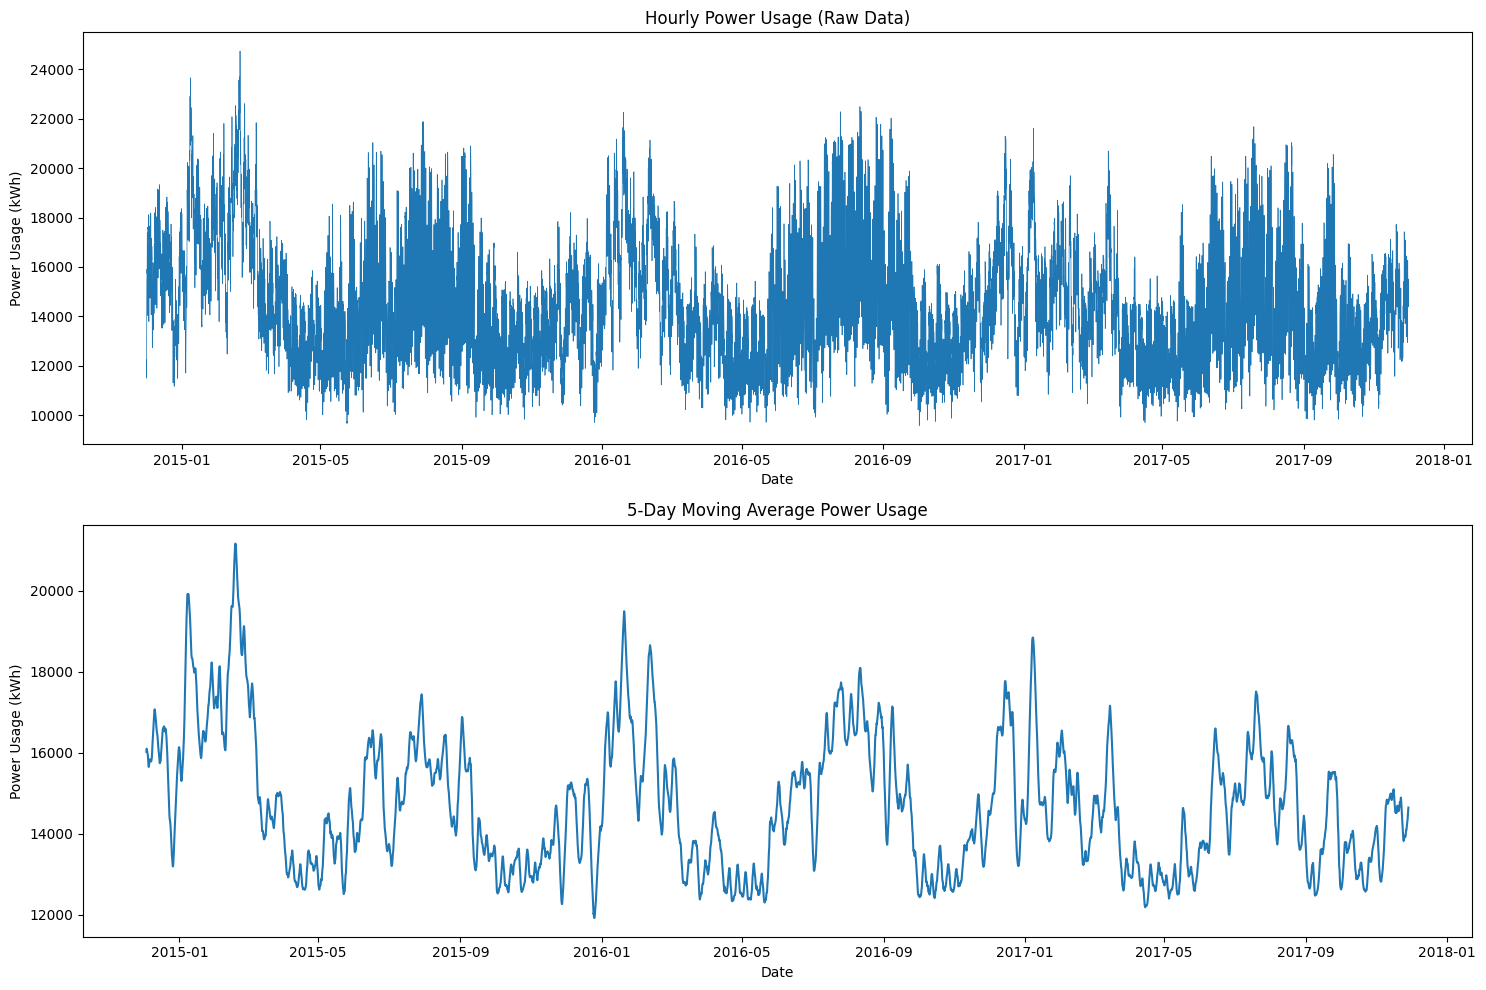

In [13]:
# Set up the plots
plt.figure(figsize=(15, 10))

# Plot 1: Raw data showing chaos
plt.subplot(2, 1, 1)
sns.lineplot(data=df, x='datetime', y='power_usage', linewidth=0.5)
plt.title('Hourly Power Usage (Raw Data)')
plt.xlabel('Date')
plt.ylabel('Power Usage (kWh)')

# Plot 2: 5-day moving average
plt.subplot(2, 1, 2)
df['power_usage_5day_ma'] = df['power_usage'].rolling(window=5*24, center=True).mean()  # 5 days * 24 hours
sns.lineplot(data=df, x='datetime', y='power_usage_5day_ma')
plt.title('5-Day Moving Average Power Usage')
plt.xlabel('Date')
plt.ylabel('Power Usage (kWh)')

plt.tight_layout()
plt.show()

These are pretty sparse when compared to the insights we have discovered through some simple approaches.

To recap, here are the approaches again:
* rearrange
* augment
* foreground

# conclusion

Note that many of these insights have not needed to aggregate nor smooth the data out.

As a result, we can gather insights that are lurking in the complex nooks and crannies of the data without getting overwhelmed nor losing resolution.

Aggregation has its place as a useful tool, however, performing the aggregation as a first step can lead us to unconsciously leave out valuable insights.